# Model Evaluation

## Seth Adams

### Overview

Continuing from the feature engineering section, all models in this notebook used a merged model which concatentated 23 computed features from image segmentation with a larger model from keras.applications. These are length_x, length_y, area, hu_moments, and haralick textures. I left out some feature calculations from mahotas because it is reasonable for a convolutional neural network to build more robust features. If you would like to add additional features then modify the segmentation class. I simply commented them out. I built all features in extracted_features.csv, and saw that image size was log distributed. In order to create a normal/ multimodal distribution I took the natural log of x_length, y_length, and area. hu_moments also had some odd distributions, but I still question whether they are even useful.

It's actually quite hard to tell if these features helped the model, but they did not lower accuracy. These features will probably only help as the data size gets larger, but I ran comparison models and didn't see much of a difference. (see 18k_aug_inception and 18k_aug_merged in ipynb_files) I started to get reasonable results when I balanced classes using sampling with replacement from the population images. This approach is not ideal since some images from training will appear in the validation set even after soft augmentation of the images. I have to work with the data given, but I believe the user will now have a more robust data pipeline to work with as the dataset size increases.

There are two files for building models. model_generator.py and model_cached.py.

**Model generator** will take much longer time to run, but is nessesary when the dataset is too large and the user runs out of RAM on their machine. This model runs using a data_generator which loads data during runtime of the model. The user should take note of the __data_generation method in data_generator.py. This method builds each batch of data by taking paths to each image with their corresponding labels at the indices from the pandas.DataFrame. Segmentation is performed on the image to preprocess to any size input to a neural network. The image is cropped and padded to the center before augmentation is applied. Idealy augmentation is performed before segmentation, but this can lead to segmentation errors if the plankton goes out of frame. If a contour can not be found in the image, everything will break, so you should test on the whole dataset first. Using a generator also gives the option to augment images differently for each batch of data. This means that data size can be artifically inflated the longer the model runs. I had some good success with this dynamic augmentation.

**Model cached** can allow the user to train the model much faster by storing images into memory before the GPU trains the neural network. This approach is good to see quick results, but does not allow for dynamic augmentation of the training set. The screenshots of model training was done using tensorboard. This includes relative timestamps. Most models built using cached only took 30 mins to train. The dynamic augmentation models from model_generator took around 12 hours to train.

### Model 1 - InceptionV3 merged with extracted features. Class weight using all data. No augmentations.

All models used a 5% validation split. Calculation of class weights via the sklearn method (compute_class_weight) was attempted. This resulted in a model that started at a very high accuracy probably due to the large amounts of data in the blob and unknown classes. The model clearly overfits the data and struggles to classify unseen data. I believe any poor validation evaluation was due to class imbalance.

![InceptionV3_class_weight](ipynb_files/class_weight_balanced.png)

### Model 2 - InceptionV3 merged with extracted features. Balanced classes. No Augmentations.

500 images per class. Images were not augmented. This model should not generalize well to unseen data. Mainly created to establish a baseline. Due to low image size per class, validation set contains images from train set. Notice how the validation always lags training by a couple percent.

![InceptionV3_no_aug](ipynb_files/17k_1k_no_aug_merged.png)

In [1]:
import pandas as pd
import pickle
from segmentation import Segmentation
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import os
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

with open('class_map.pickle', 'rb') as handle:
    class_map = pickle.load(handle)

with open('normalizer.pickle', 'rb') as handle:
    mms = pickle.load(handle)

df = pd.read_csv('plankton.csv')
df.drop_duplicates(subset='im_name', inplace=True)
df.sample(5)

Using TensorFlow backend.


,im_name,label
5524,SPC-PWSSC-1466285520-000422-621-1614-374-64-36...,13
3823,SPC-PWSSC-1473111243-000709-024-640-1918-116-1...,8
186,SPC-PWSSC-0-000836-107-1640-2234-44-84.png,3
2981,SPC-PWSSC-1466674323-000428-085-2300-2156-44-5...,3
8932,SPC-PWSSC-1462860145-000054-043-2542-2426-208-...,36


In [2]:
input_shape = (75, 75, 3)
feat_shape = (23,)

X_img = np.empty((df.shape[0], input_shape[0], input_shape[1], input_shape[2]), dtype=np.uint8)
X_feat = np.empty((df.shape[0], feat_shape[0]))

data_path = os.path.join(os.getcwd(), 'data')

for i, (im_name, label) in enumerate(zip(df.im_name, df.label)):
    im_dir = os.path.join(data_path, class_map[label])
    im_path = os.path.join(im_dir, im_name)
    plankton = Segmentation(im_path, target_shape=input_shape)
    plankton.segment()
    padded = plankton.get_padded()
    X_img[i,] = preprocess_input(padded)
    X_feat[i,] = plankton.get_features()

X_feat = mms.transform(X_feat)

X = [X_img, X_feat]

print(X_img.shape)
print(X_feat.shape)

(10890, 75, 75, 3)
(10890, 23)


Here is the model summary. You can see the concatenation of a new input layer which contains the calculated features.

In [3]:
model = load_model('./models/inception_v3_merged_no_aug_cached.model')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 1, 1, 2048)   21802784    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_1 (D

In [4]:
def eval_model(model):

    y_pred = []

    for i in range(X_img.shape[0]):
        x_img = X_img[i].reshape(1, input_shape[0], input_shape[1], input_shape[2])
        x_feat = X_feat[i].reshape(1, feat_shape[0])
        y_hat = model.predict([x_img, x_feat])
        y_pred.append(np.argmax(y_hat))
        
    return y_pred

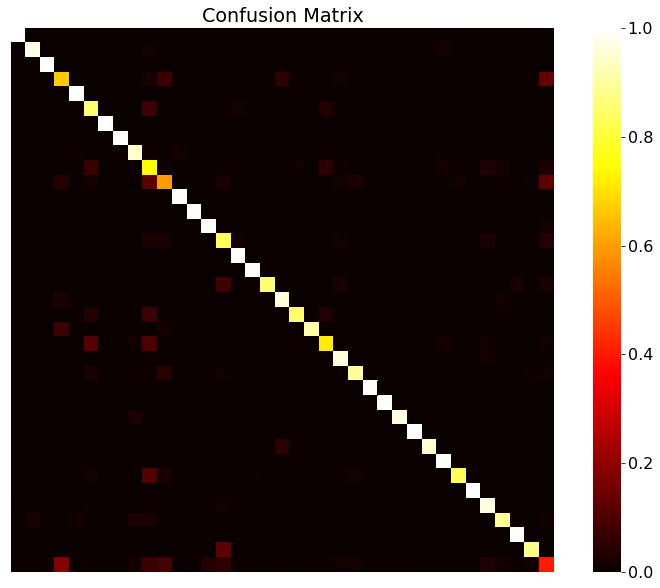

Accuracy: 0.6803
F1 Score: 0.6745
These classes performed under the 0.8 accuracy threshold.

Blob performed with an accuracy of 0.666
Cope_lg performed with an accuracy of 0.739
Cope_sm performed with an accuracy of 0.595
Neocalanus performed with an accuracy of 0.718
Unknown performed with an accuracy of 0.406


In [5]:
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (14,10)
mpl.rcParams['axes.labelsize'] = 16

y_pred = eval_model(model)
acc = str(round(accuracy_score(df.label, y_pred), 4))
f1 = str(round(f1_score(df.label, y_pred, average='weighted'), 4))
conf_mat = confusion_matrix(df.label, y_pred)
conf_mat = conf_mat.astype(dtype=np.float16)
for row in range(conf_mat.shape[0]):
    conf_mat[row,:] = conf_mat[row,:] / sum(conf_mat[row,:])

plt.title('Confusion Matrix')
sns.heatmap(conf_mat, cmap='hot', square=True, xticklabels=False, yticklabels=False)
plt.show()

print('Accuracy: {}'.format(acc))
print('F1 Score: {}'.format(f1))

threshold = 0.8
print('These classes performed under the {} accuracy threshold.\n'.format(threshold))
for i in range(conf_mat.shape[0]):
    if conf_mat[i,i] < threshold:
        print('{} performed with an accuracy of {}'.format(class_map[i], str(round(conf_mat[i,i], 3))))

These results were expected from this classifier. Each class was given 500 images sampled from population with replacement. Idealy no replacement would be nessesary, but classes are severely unbalanced. As it turns out, all the poor performing classes had a large number of images in them. Often over 500. It seems reasonable for the algorithm to struggle with new images it has never seen before. Lets now try some image augmentation and see if that helps with the unseen images.

### Augmentation demo

Image augmentation were performed using the imgaug library. https://imgaug.readthedocs.io/en/latest/

Image augmentation is quite common even when the user has a large data size. I used fairly light augmentation because certain affine transformations such as cropping or translating can remove the plankton from the image. This can cause segmentation errors and break everything. So lets go over a use case.

The following augmentations are applied in a random order:

 - Horizontal flip (50%)
 - Gaussian Blur between 0 and 0.2 sigma (50%)
 - Multiply between 0.6 and 1.4 (brighter and darker)
 - Affine transformations
     * Scale x and y between 0.8 and 1.2
     * Rotate between -90 and 90
     * Shear between -8 and 8

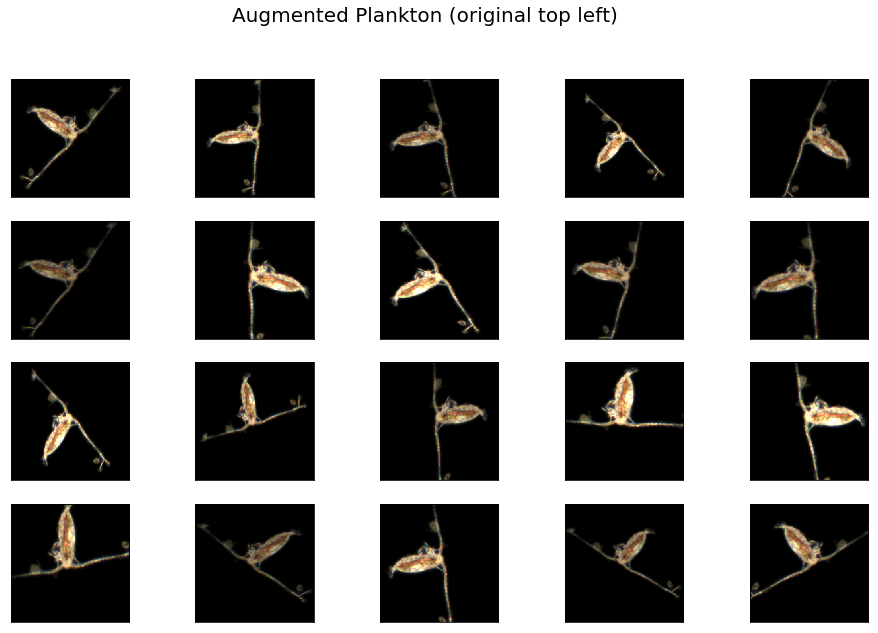

In [6]:
from augment import seq

def plot_images(images):
    fig, axes = plt.subplots(nrows=4, ncols=5, sharex=False,
                             sharey=True, figsize=(16,10))
    fig.suptitle('Augmented Plankton (original top left)', size=20)
    i = 0
    for x in range(4):
        for y in range(5):
            axes[x,y].imshow(images[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

data_path = os.path.join(os.getcwd(), 'data')
class_path = os.path.join(data_path, 'Calanus')
im_path = os.path.join(class_path, 'SPC-PWSSC-0-000901-093-2938-1440-404-408.png')

images = []
plankton = Segmentation(im_path)
plankton.segment()
padded = plankton.get_padded()
images.append(padded)
for _ in range(19):
    aug = seq.augment_image(padded)
    images.append(aug)
plot_images(images)
plt.show()

### Model 3 - InceptionV3 merged with features. Balanced classes. Augmentations every batch. Static validation.

I expect this model to perform well since I increased to 3k images per class. Augmentations are applied on the training set. Validation set was not augmented. Notice how the model generalizes well to validation with an accuracy of around 90%. This is the kind of performance I would expect as your data size increases. For the rest of this notebook, model results will be calculated using the evaluate_model.py file since it takes so long to run the models and sometimes data is switched out. Results are pulled from the model_results directory.

![InceptionV3_gen_static_val](ipynb_files/3k_aug_static_val.png)

In [128]:
def build_conf_mat(file_name):
    csv_dir = os.path.join(os.getcwd(), 'model_results')
    csv_path = os.path.join(csv_dir, file_name)
    df = pd.read_csv(csv_path)

    acc = str(round(accuracy_score(df.y_true, df.y_pred), 4))
    f1 = str(round(f1_score(df.y_true, df.y_pred, average='weighted'), 4))
    conf_mat = confusion_matrix(df.y_true, df.y_pred)
    conf_mat = conf_mat.astype(dtype=np.float16)
    for row in range(conf_mat.shape[0]):
        conf_mat[row,:] = conf_mat[row,:] / sum(conf_mat[row,:])

    plt.title('Confusion Matrix: {}'.format(file_name))
    sns.heatmap(conf_mat, cmap='hot', square=True, xticklabels=False, yticklabels=False)
    plt.show()

    print('Accuracy: {}'.format(acc))
    print('F1 Score: {}'.format(f1))
    
    return conf_mat
    
def get_low_acc_classes(conf_mat, threshold=0.8):
    threshold = 0.8
    low_classes = []
    print('\nThese classes performed under the {} accuracy threshold.\n'.format(threshold))
    for i in range(conf_mat.shape[0]):
        if conf_mat[i,i] < threshold:
            low_classes.append(i)
            print('{} performed with an accuracy of {}'.format(class_map[i], str(round(conf_mat[i,i], 3))))
    return low_classes

def get_low_acc_class_conflicts(conf_mat, low_classes, threshold=0.05):
    for i in range(conf_mat.shape[0]):
        conf_mat[i][i] = 0.0
    x, y = np.where(conf_mat > 0.1)
    blank = np.zeros(conf_mat.shape)
    for i, j in zip(x, y):
        blank[i,j] = conf_mat[i][j]
    sns.heatmap(blank, vmin=0.0, vmax=1.0, cmap='hot', square=True, xticklabels=False, yticklabels=False)
    plt.show()
    
    

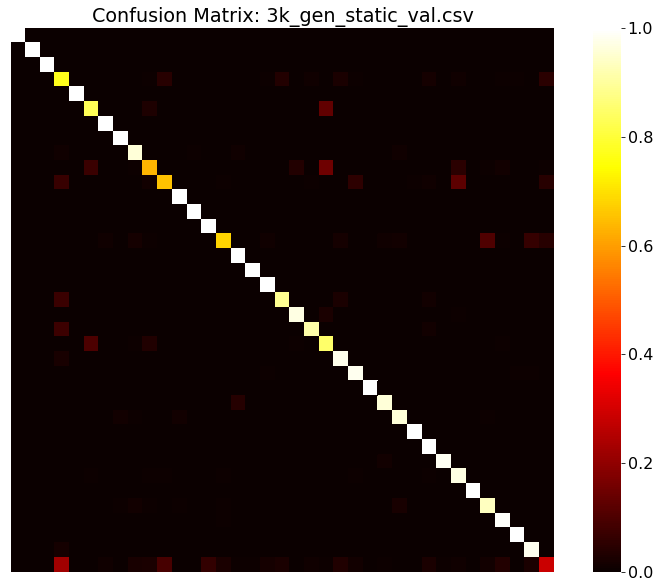

Accuracy: 0.6848
F1 Score: 0.67

These classes performed under the 0.8 accuracy threshold.

Blob performed with an accuracy of 0.77
Cope_lg performed with an accuracy of 0.636
Cope_sm performed with an accuracy of 0.652
Filament performed with an accuracy of 0.682
Unknown performed with an accuracy of 0.286


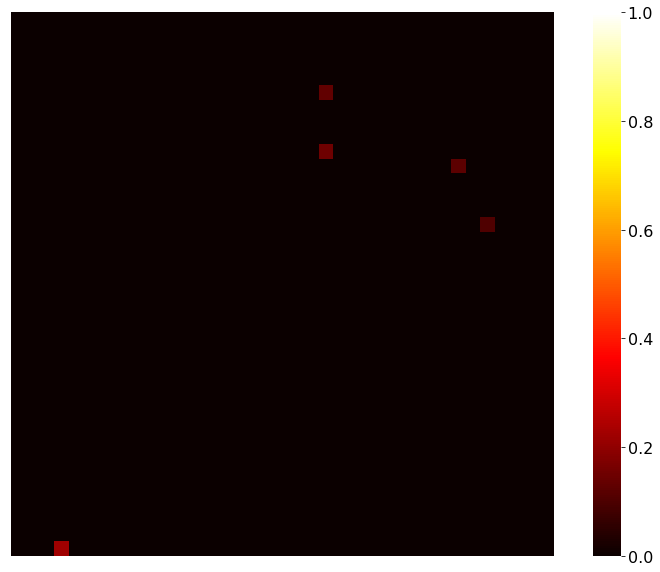

In [129]:
conf_mat = build_conf_mat('3k_gen_static_val.csv')
low_classes = get_low_acc_classes(conf_mat)
get_low_acc_class_conflicts(conf_mat, low_classes)